In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# import seaborn as sns
# import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
from transformers import RobertaTokenizer, TFRobertaModel

In [3]:
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
df = pd.read_csv("..//efcamdat_sub.csv")

In [5]:
df['cefr_numeric'].value_counts()

cefr_numeric
3    100000
2    100000
1    100000
4     61329
5     14698
6      1940
Name: count, dtype: int64

In [6]:
df.columns

Index(['id', 'level', 'unit', 'learner_id', 'learner_nationality', 'grade',
       'date', 'topic_id', 'text', 'cefr_numeric', 'cefr_grouped'],
      dtype='object')

In [7]:
df.shape[0]

377967

In [8]:
df['labels'] = df['cefr_numeric'].apply(lambda x: x-1)

In [9]:
text = df['text']
labels = df['labels']

In [10]:
(train_texts, test_texts, train_labels, test_labels) = train_test_split(text, labels, test_size=.1, shuffle=True)

In [11]:
len(test_texts)

37797

In [12]:
len(train_texts)

340170

In [13]:
# valid_texts_s = train_texts.iloc[:1000]
# valid_labels_s = train_labels.iloc[:1000]
# train_texts_s = train_texts.iloc[1000:20000]
# train_labels_s = train_labels.iloc[1000:20000]
# test_texts_s = test_texts.iloc[:1000]
# test_labels_s = test_labels.iloc[:1000]

valid_texts = train_texts.iloc[:40607].copy()
valid_labels = train_labels.iloc[:40607].copy()
train_texts = train_texts.iloc[40607:]
train_labels = train_labels.iloc[40607:]

In [14]:
(pd.DataFrame(data={'text': train_texts, 'labels': train_labels})).to_csv('..//efcamdat_train_data.csv')

In [15]:
max_length = 150

In [16]:
rtokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [17]:
class SNLIDataGeneratorFromFile(tf.keras.utils.Sequence):

    def __init__(self,
                 tokenizer,
                 n_examples,
                 data_filename,
                 max_length=100,
                 batch_size=128,
                 shuffle=True):

        self.tokenizer = tokenizer
        self.n_examples = n_examples
        self.data_filename = data_filename
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()

    def __len__(self):
        # Return the number of batches in the full dataset
        return self.n_examples // self.batch_size

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size

        # Indices to skip are the ones in the shuffled row_order before and
        # after the chunk we'll use for this batch
        batch_idx_skip = self.row_order[:batch_start] + self.row_order[batch_end:]
        df = pd.read_csv(self.data_filename, skiprows=batch_idx_skip)

        texts = df['text'].values.astype(str).tolist()
        labels = df['labels'].values

        tokens = rtokenizer(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

        input_ids = np.array(tokens["input_ids"], dtype="int32")
        attention_masks = np.array(tokens["attention_mask"], dtype="int32")
    
        return [input_ids, attention_masks], labels

    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

In [18]:
#train_encodings = rtokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
train_data_generator = SNLIDataGeneratorFromFile(
    tokenizer=rtokenizer,
    n_examples=len(train_texts),
    data_filename='..//efcamdat_train_data.csv'
)

valid_encodings = rtokenizer(list(valid_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [19]:
def create_roberta_cl_model(model,
                         num_classes = 6,
                         dropout=0.3,
                         learning_rate=0.0001):
    """
    """
    model.trainable = False

    #tf.keras.mixed_precision.set_global_policy('mixed_float16')

    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    #token_type_ids = tf.keras.layers.Input(shape=(300,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    model_inputs = [input_ids, attention_mask]
    model_out = model(input_ids=input_ids, attention_mask=attention_mask)

    model_out = model_out.last_hidden_state

    conv = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu')(model_out)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    lstm = tf.keras.layers.LSTM(units=256, return_sequences=False, return_state=False)(conv)
    lstm = tf.keras.layers.Dropout(dropout)(lstm)
    # dense = tf.keras.layers.Dense(256, activation='relu')(lstm)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(lstm)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.1)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [20]:
def create_roberta_gru_model(model,
                         num_classes = 6,
                         dropout=0.3,
                         learning_rate=0.0001):
    """
    """
    model.trainable = False

    tf.keras.mixed_precision.set_global_policy('mixed_float16')

    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    #token_type_ids = tf.keras.layers.Input(shape=(300,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    model_inputs = [input_ids, attention_mask]
    model_out = model(input_ids=input_ids, attention_mask=attention_mask)

    model_out = model_out.last_hidden_state

    conv = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu')(model_out)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    gru = tf.keras.layers.GRU(256)(conv)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(gru)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.1)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [21]:
roberta_cl_model = create_roberta_cl_model(model=roberta_model, num_classes=6)

In [22]:
roberta_cl_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids_layer[0][0]',        
 el)                            thPoolingAndCrossAt               'attention_mask_layer[0][0]']   
                                tentions(last_hidde                                           

In [23]:
# dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": train_encodings.input_ids, "attention_mask_layer": train_encodings.attention_mask}, train_labels))
# dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": valid_encodings.input_ids, "attention_mask_layer": valid_encodings.attention_mask}, valid_labels))
vdataset = vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [24]:
import gc
from tensorflow.keras.backend import clear_session

# Clear session and free memory before starting the training
clear_session()
gc.collect()

26526

In [25]:
# test_model_history = test_model2.fit([train_encodings.input_ids, train_encodings.attention_mask],
#                                       train_labels,
#                                       validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask],
#                                       valid_labels),
#                                       batch_size=32,
#                                       epochs=3)

roberta_cl_model_history = roberta_cl_model.fit(train_data_generator,
                                      validation_data=vdataset,
                                      epochs=3)

Epoch 1/3
2340/2340 [==============================] - 1646s 694ms/step - loss: 0.4316 - accuracy: 0.8490 - val_loss: 0.2722 - val_accuracy: 0.9074
Epoch 2/3
2340/2340 [==============================] - 1929s 824ms/step - loss: 0.2248 - accuracy: 0.9252 - val_loss: 0.2097 - val_accuracy: 0.9325
Epoch 3/3
2340/2340 [==============================] - 1973s 843ms/step - loss: 0.1686 - accuracy: 0.9441 - val_loss: 0.1380 - val_accuracy: 0.9542


In [26]:
test_encodings = rtokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [27]:
tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": test_encodings.input_ids, "attention_mask_layer": test_encodings.attention_mask}, test_labels))
tdataset = tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [28]:
roberta_cl_model.evaluate(tdataset)

1182/1182 [==============================] - 163s 138ms/step - loss: 0.1357 - accuracy: 0.9553


[0.13572627305984497, 0.9552874565124512]

In [29]:
preds = roberta_cl_model.predict(tdataset)

1182/1182 [==============================] - 165s 137ms/step


In [30]:
preds = tf.argmax(preds, axis=-1)

In [31]:
print(classification_report(test_labels, preds.numpy()))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     10103
           1       0.97      0.96      0.96      9890
           2       0.96      0.96      0.96      9972
           3       0.92      0.95      0.94      6204
           4       0.90      0.80      0.85      1446
           5       0.89      0.55      0.68       182

    accuracy                           0.96     37797
   macro avg       0.94      0.87      0.89     37797
weighted avg       0.96      0.96      0.95     37797



In [32]:
cm = tf.math.confusion_matrix(test_labels, preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

In [33]:
cm

<tf.Tensor: shape=(6, 6), dtype=float64, numpy=
array([[9.81688607e-01, 1.20756211e-02, 2.77145402e-03, 2.37553202e-03,
        1.08878551e-03, 0.00000000e+00],
       [1.78968655e-02, 9.58240647e-01, 1.57735086e-02, 6.67340748e-03,
        1.41557128e-03, 0.00000000e+00],
       [5.51544324e-03, 9.62695548e-03, 9.55475331e-01, 2.46690734e-02,
        4.51263538e-03, 2.00561572e-04],
       [6.76982592e-03, 8.38168923e-03, 2.33720181e-02, 9.54867827e-01,
        6.12508059e-03, 4.83558994e-04],
       [3.18118949e-02, 1.38312586e-02, 4.35684647e-02, 1.04426003e-01,
        8.01521438e-01, 4.84094053e-03],
       [2.19780220e-02, 2.19780220e-02, 4.94505495e-02, 2.63736264e-01,
        8.79120879e-02, 5.54945055e-01]])>

Text(220.72222222222223, 0.5, 'True')

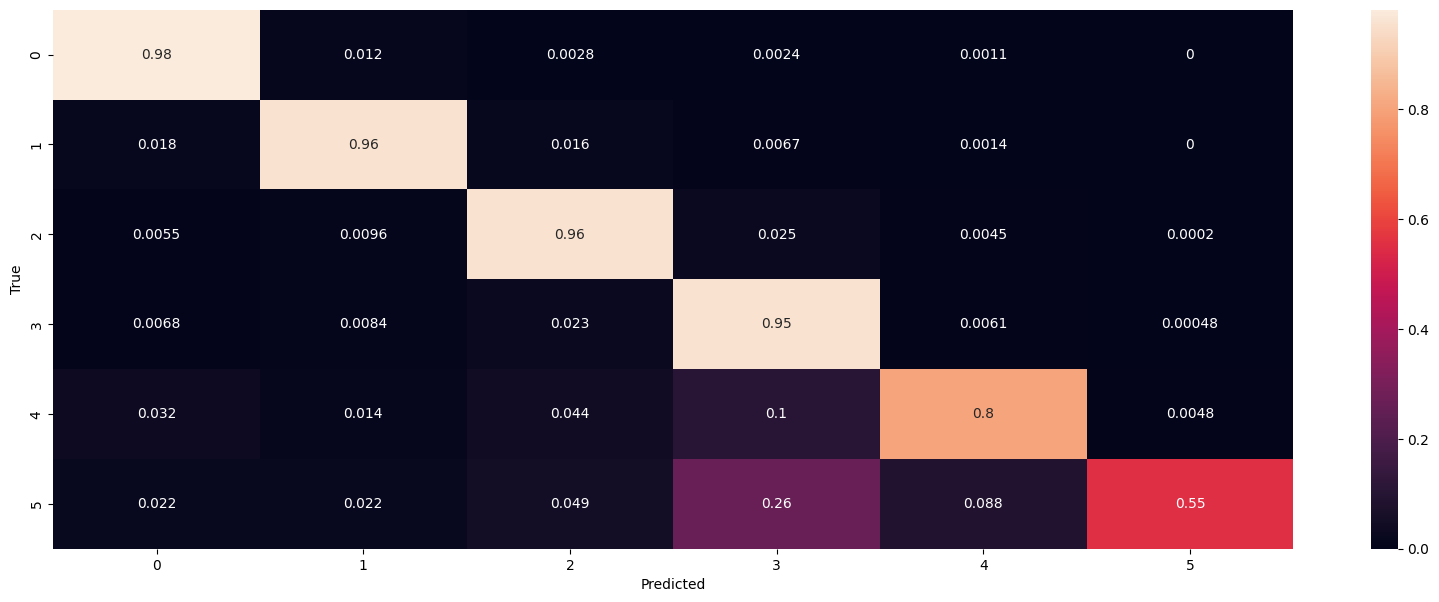

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

In [35]:
print("The % of A1s is: ", df['cefr_numeric'].value_counts()[1] / len(df))
print("The % of A2s is: ", df['cefr_numeric'].value_counts()[2] / len(df))
print("The % of B1s is: ", df['cefr_numeric'].value_counts()[3] / len(df))
print("The % of B2s is: ", df['cefr_numeric'].value_counts()[4] / len(df))
print("The % of C1s is: ", df['cefr_numeric'].value_counts()[5] / len(df))

The % of A1s is:  0.2645733622247445
The % of A2s is:  0.2645733622247445
The % of B1s is:  0.2645733622247445
The % of B2s is:  0.16226019731881355
The % of C1s is:  0.03888699277979295


In [36]:
roberta_cl_model.save('roberta-cl.keras')

## GRU

In [37]:
roberta_gru_model = create_roberta_gru_model(model=roberta_model, num_classes=6)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


In [38]:
# dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": train_encodings.input_ids, "attention_mask_layer": train_encodings.attention_mask}, train_labels))
# dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": valid_encodings.input_ids, "attention_mask_layer": valid_encodings.attention_mask}, valid_labels))
vdataset = vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [39]:
roberta_gru_model_history = roberta_gru_model.fit(train_data_generator,
                                      validation_data=vdataset,
                                      epochs=1)

2340/2340 [==============================] - 1772s 752ms/step - loss: 0.4738 - accuracy: 0.8280 - val_loss: 0.3176 - val_accuracy: 0.8947


In [40]:
test_encodings = rtokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [41]:
tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": test_encodings.input_ids, "attention_mask_layer": test_encodings.attention_mask}, test_labels))
tdataset = tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [42]:
preds = roberta_gru_model.predict(tdataset)

1182/1182 [==============================] - 164s 137ms/step


In [43]:
preds = tf.argmax(preds, axis=-1)

In [44]:
print(classification_report(test_labels, preds.numpy()))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10103
           1       0.95      0.87      0.91      9890
           2       0.81      0.97      0.89      9972
           3       0.92      0.80      0.86      6204
           4       0.76      0.68      0.72      1446
           5       0.00      0.00      0.00       182

    accuracy                           0.90     37797
   macro avg       0.73      0.71      0.72     37797
weighted avg       0.90      0.90      0.89     37797



C:\Users\Danny Skahill\miniconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Danny Skahill\miniconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Danny Skahill\miniconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [45]:
cm = tf.math.confusion_matrix(test_labels, preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

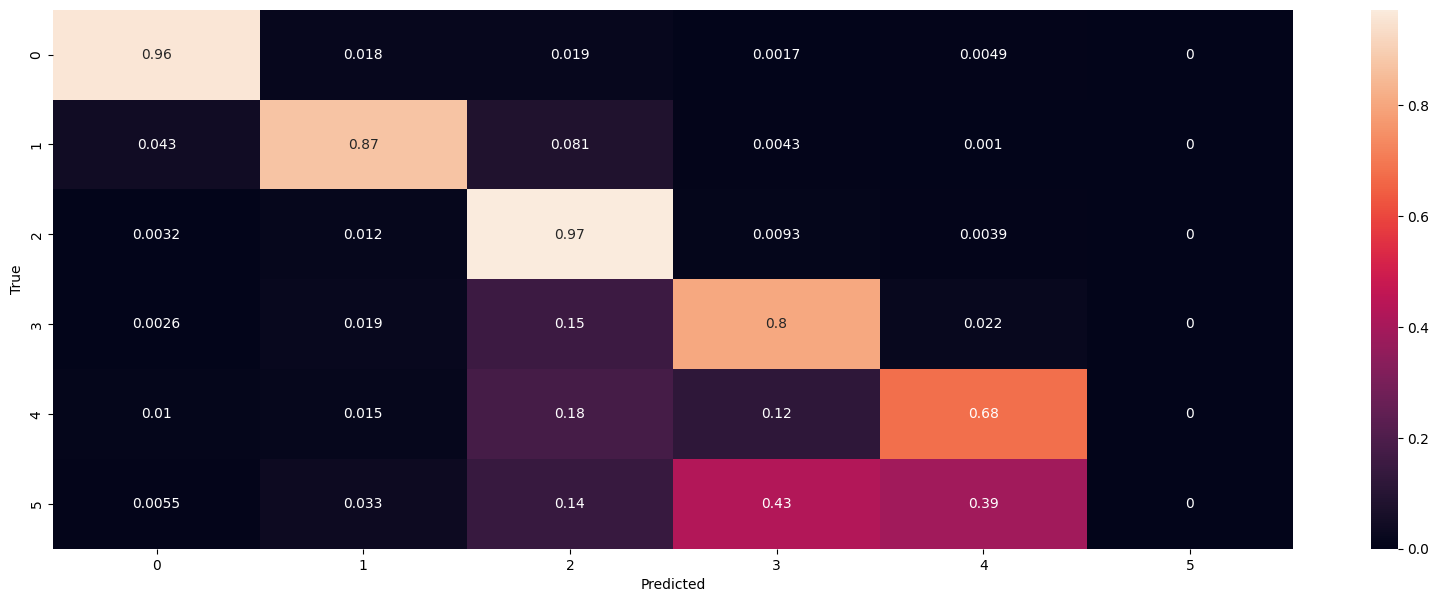

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

## 3->6 Class Model

In [47]:
train_labels_group = train_labels.copy()
train_labels_group[train_labels_group == 1] = 0
train_labels_group[(train_labels_group == 2) | (train_labels_group == 3)] = 1
train_labels_group[(train_labels_group == 4) | (train_labels_group == 5)] = 2

valid_labels_group = valid_labels.copy()
valid_labels_group[valid_labels_group == 1] = 0
valid_labels_group[(valid_labels_group == 2) | (valid_labels_group == 3)] = 1
valid_labels_group[(valid_labels_group == 4) | (valid_labels_group == 5)] = 2

test_labels_group = test_labels.copy()
test_labels_group[test_labels_group == 1] = 0
test_labels_group[(test_labels_group == 2) | (test_labels_group == 3)] = 1
test_labels_group[(test_labels_group == 4) | (test_labels_group == 5)] = 2

In [48]:
roberta_model_grouped = create_roberta_gru_model(model=roberta_model, num_classes=3)

In [49]:
# dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": train_encodings.input_ids, "attention_mask_layer": train_encodings.attention_mask}, train_labels_group))
# dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": valid_encodings.input_ids, "attention_mask_layer": valid_encodings.attention_mask}, valid_labels_group))
vdataset = vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [50]:
roberta_grouped_history = roberta_model_grouped.fit(train_data_generator,
                                      validation_data=vdataset,
                                      epochs=1)

2340/2340 [==============================] - 1777s 754ms/step - loss: nan - accuracy: 0.2570 - val_loss: 1.0040 - val_accuracy: 0.5268


In [51]:
tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": test_encodings.input_ids, "attention_mask_layer": test_encodings.attention_mask}, test_labels_group))
tdataset = tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [52]:
roberta_model_grouped.evaluate(tdataset)

1182/1182 [==============================] - 164s 138ms/step - loss: 1.0053 - accuracy: 0.5255


[1.0053349733352661, 0.5254914164543152]

In [53]:
preds = roberta_model_grouped.predict(tdataset)
preds = tf.argmax(preds, axis=-1)

1182/1182 [==============================] - 165s 137ms/step


In [54]:
cm = tf.math.confusion_matrix(test_labels_group, preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

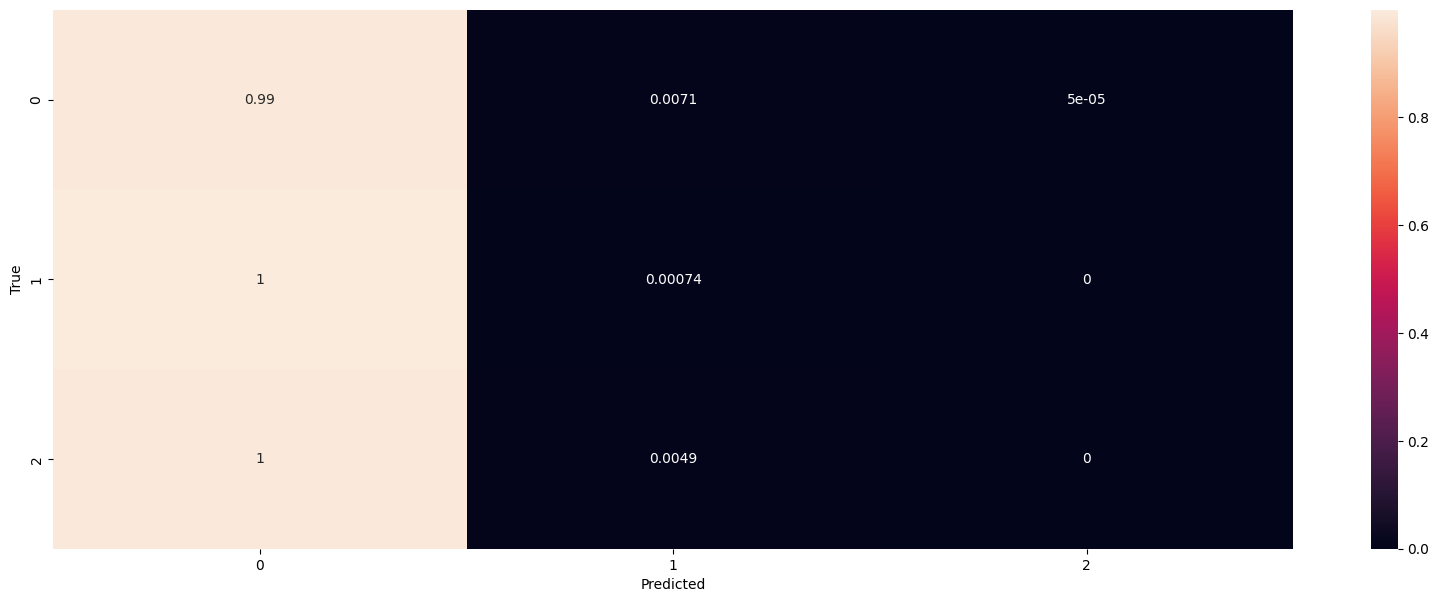

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

### Discriminate betweeen A1/A2, B1/B2, C1/C2

In [56]:
#A
A_train_mask = tf.equal(train_labels_group, 0)
A_train_encodings = {"input_ids": tf.boolean_mask(train_encodings['input_ids'], A_train_mask),
                     "attention_mask": tf.boolean_mask(train_encodings['attention_mask'], A_train_mask)}
A_train_labels =  tf.boolean_mask(train_labels.copy(), A_train_mask)
A_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": A_train_encodings['input_ids'], "attention_mask_layer": A_train_encodings['attention_mask']}, A_train_labels))
A_dataset = A_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

A_valid_mask = tf.equal(valid_labels_group, 0)
A_valid_encodings = {"input_ids": tf.boolean_mask(valid_encodings['input_ids'], A_valid_mask),
                     "attention_mask": tf.boolean_mask(valid_encodings['attention_mask'], A_valid_mask)}
A_valid_labels =  tf.boolean_mask(valid_labels.copy(), A_valid_mask)
A_vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": A_valid_encodings['input_ids'], "attention_mask_layer": A_valid_encodings['attention_mask']}, A_valid_labels))
A_vdataset = A_vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

A_test_mask = tf.equal(test_labels_group, 0)
A_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], A_test_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], A_test_mask)}
A_test_labels =  tf.boolean_mask(test_labels.copy(), A_test_mask)
A_tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": A_test_encodings['input_ids'], "attention_mask_layer": A_test_encodings['attention_mask']}, A_test_labels))
A_tdataset = A_tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

NameError: name 'train_encodings' is not defined

In [ ]:
A_model = create_roberta_gru_model(model=roberta_model, num_classes=2)

In [ ]:
A_model_history = A_model.fit(A_dataset,
                            validation_data=A_vdataset,
                            epochs=1)

In [ ]:
#B
B_train_mask = tf.equal(train_labels_group, 1)
B_train_encodings = {"input_ids": tf.boolean_mask(train_encodings['input_ids'], B_train_mask),
                     "attention_mask": tf.boolean_mask(train_encodings['attention_mask'], B_train_mask)}
B_train_labels =  tf.boolean_mask(train_labels.copy(), B_train_mask) - 2
B_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": B_train_encodings['input_ids'], "attention_mask_layer": B_train_encodings['attention_mask']}, B_train_labels))
B_dataset = B_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

B_valid_mask = tf.equal(valid_labels_group, 1)
B_valid_encodings = {"input_ids": tf.boolean_mask(valid_encodings['input_ids'], B_valid_mask),
                     "attention_mask": tf.boolean_mask(valid_encodings['attention_mask'], B_valid_mask)}
B_valid_labels =  tf.boolean_mask(valid_labels.copy(), B_valid_mask) - 2
B_vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": B_valid_encodings['input_ids'], "attention_mask_layer": B_valid_encodings['attention_mask']}, B_valid_labels))
B_vdataset = B_vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

B_test_mask = tf.equal(test_labels_group, 1)
B_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], B_test_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], B_test_mask)}
B_test_labels =  tf.boolean_mask(test_labels.copy(), B_test_mask) - 2
B_tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": B_test_encodings['input_ids'], "attention_mask_layer": B_test_encodings['attention_mask']}, B_test_labels))
B_tdataset = B_tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
B_model = create_roberta_gru_model(model=roberta_model, num_classes=2)

In [ ]:
B_model_history = B_model.fit(B_dataset,
                              validation_data=B_vdataset,
                              epochs=1)

In [ ]:
#C
C_train_mask = tf.equal(train_labels_group, 2)
C_train_encodings = {"input_ids": tf.boolean_mask(train_encodings['input_ids'], C_train_mask),
                     "attention_mask": tf.boolean_mask(train_encodings['attention_mask'], C_train_mask)}
C_train_labels =  tf.boolean_mask(train_labels.copy(), C_train_mask) - 4
C_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": C_train_encodings['input_ids'], "attention_mask_layer": C_train_encodings['attention_mask']}, C_train_labels))
C_dataset = C_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

C_valid_mask = tf.equal(valid_labels_group, 2)
C_valid_encodings = {"input_ids": tf.boolean_mask(valid_encodings['input_ids'], C_valid_mask),
                     "attention_mask": tf.boolean_mask(valid_encodings['attention_mask'], C_valid_mask)}
C_valid_labels =  tf.boolean_mask(valid_labels.copy(), C_valid_mask) - 4
C_vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": C_valid_encodings['input_ids'], "attention_mask_layer": C_valid_encodings['attention_mask']}, C_valid_labels))
C_vdataset = C_vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

C_test_mask = tf.equal(test_labels_group, 2)
C_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], C_test_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], C_test_mask)}
C_test_labels =  tf.boolean_mask(test_labels.copy(), C_test_mask) - 4
C_tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": C_test_encodings['input_ids'], "attention_mask_layer": C_test_encodings['attention_mask']}, C_test_labels))
C_tdataset = C_tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
C_model = create_roberta_gru_model(model=roberta_model, num_classes=2)

In [ ]:
C_model_history = C_model.fit(C_dataset,
                              validation_data=C_vdataset,
                              epochs=1)

### Combine

In [ ]:
a_pred_mask = tf.equal(preds, 0)
b_pred_mask = tf.equal(preds, 1)
c_pred_mask = tf.equal(preds, 2)

a_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], a_pred_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], a_pred_mask)}
a_preds = A_model.predict([a_test_encodings['input_ids'], a_test_encodings["attention_mask"]])
a_preds = tf.argmax(a_preds, axis=-1)
a_preds = a_preds.numpy() 

b_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], b_pred_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], b_pred_mask)}
b_preds = B_model.predict([b_test_encodings['input_ids'], b_test_encodings["attention_mask"]])
b_preds = tf.argmax(b_preds, axis=-1)
b_preds = b_preds.numpy() + 2

c_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], c_pred_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], c_pred_mask)}
c_preds = C_model.predict([c_test_encodings['input_ids'], c_test_encodings["attention_mask"]])
c_preds = tf.argmax(c_preds, axis=-1)
c_preds = c_preds.numpy() + 4


predictions_comb = preds.numpy()
predictions_comb[a_pred_mask] = a_preds
predictions_comb[b_pred_mask] = b_preds
predictions_comb[c_pred_mask] = c_preds

In [ ]:
cm = tf.math.confusion_matrix(test_labels, predictions_comb)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

In [ ]:
print(classification_report(test_labels, predictions_comb))

## Multi-Step Model

In [61]:
#del vdataset
del tdataset
del dataset

### Step 1

In [48]:
s1_train_labels = train_labels.copy()
s1_train_labels[(s1_train_labels == 5) | (s1_train_labels == 4)] = 3

s1_valid_labels = valid_labels.copy()
s1_valid_labels[(s1_valid_labels == 5) | (s1_valid_labels == 4)] = 3

s1_test_labels = test_labels.copy()
s1_test_labels[(s1_test_labels == 5) | (s1_test_labels == 4)] = 3

In [49]:
s1_roberta_model = create_roberta_cl_model(model=roberta_model, num_classes=4)

In [50]:
dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": train_encodings.input_ids, "attention_mask_layer": train_encodings.attention_mask}, s1_train_labels))
dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": valid_encodings.input_ids, "attention_mask_layer": valid_encodings.attention_mask}, s1_valid_labels))
vdataset = vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [51]:
s1_roberta_history = s1_roberta_model.fit(dataset,
                                      validation_data=vdataset,
                                      epochs=1)

9362/9362 [==============================] - 1168s 124ms/step - loss: 0.3031 - accuracy: 0.8897 - val_loss: 0.1552 - val_accuracy: 0.9449


In [52]:
tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": test_encodings.input_ids, "attention_mask_layer": test_encodings.attention_mask}, s1_test_labels))
tdataset = tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [53]:
s1_roberta_model.evaluate(tdataset)

1182/1182 [==============================] - 114s 97ms/step - loss: 0.1570 - accuracy: 0.9455


[0.15700982511043549, 0.9454983472824097]

In [72]:
predictions_s1 = s1_roberta_model.predict([test_encodings['input_ids'], test_encodings["attention_mask"]])
predictions_s1 = tf.argmax(predictions_s1, axis=-1)

1182/1182 [==============================] - 119s 98ms/step


### Step 2

In [67]:
train_mask = tf.equal(s1_train_labels, 3)
s2_train_encodings = {"input_ids": tf.boolean_mask(train_encodings['input_ids'], train_mask),
                     "attention_mask": tf.boolean_mask(train_encodings['attention_mask'], train_mask)}
s2_train_labels =  tf.boolean_mask(train_labels.copy(), train_mask) -3
s2_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": s2_train_encodings['input_ids'], "attention_mask_layer": s2_train_encodings['attention_mask']}, s2_train_labels))
s2_dataset = s2_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


valid_mask = tf.equal(s1_valid_labels, 3)
s2_valid_encodings = {"input_ids": tf.boolean_mask(valid_encodings['input_ids'], valid_mask),
                     "attention_mask": tf.boolean_mask(valid_encodings['attention_mask'], valid_mask)}
s2_valid_labels = tf.boolean_mask(valid_labels.copy(), valid_mask) - 3
s2_vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": s2_valid_encodings['input_ids'], "attention_mask_layer": s2_valid_encodings['attention_mask']}, s2_valid_labels))
s2_vdataset = s2_vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

test_mask = tf.equal(s1_test_labels, 3)
s2_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], test_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], test_mask)}
s2_test_labels = tf.boolean_mask(test_labels.copy(), test_mask) - 3
s2_tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": s2_test_encodings['input_ids'], "attention_mask_layer": s2_test_encodings['attention_mask']}, s2_test_labels))
s2_tdataset = s2_tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [68]:
s2_roberta_model = create_roberta_cl_model(model=roberta_model, num_classes=3)

In [69]:
s2_roberta_history = s2_roberta_model.fit(s2_dataset,
                                      validation_data=s2_vdataset,
                                      epochs=1)

1932/1932 [==============================] - 254s 125ms/step - loss: 0.3297 - accuracy: 0.8851 - val_loss: 0.2267 - val_accuracy: 0.9234


In [73]:
predictions_s2 = s2_roberta_model.predict([s2_test_encodings['input_ids'], s2_test_encodings["attention_mask"]])
predictions_s2 = tf.argmax(predictions_s2, axis=-1)

243/243 [==============================] - 27s 98ms/step


### Combine

In [86]:
pred_mask = tf.equal(predictions_s1, 3)
s2_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], pred_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], pred_mask)}
predictions_s2_2 = s2_roberta_model.predict([s2_test_encodings['input_ids'], s2_test_encodings["attention_mask"]])
predictions_s2_2 = tf.argmax(predictions_s2_2, axis=-1)

predictions_s2_2 = predictions_s2_2.numpy() + 3

predictions_comb = predictions_s1.numpy()
predictions_comb[pred_mask] = predictions_s2_2

233/233 [==============================] - 23s 99ms/step


In [87]:
print(classification_report(test_labels, predictions_comb))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9960
           1       0.95      0.95      0.95     10064
           2       0.93      0.94      0.93     10008
           3       0.90      0.89      0.89      6042
           4       0.81      0.72      0.76      1535
           5       0.73      0.29      0.42       188

    accuracy                           0.93     37797
   macro avg       0.88      0.80      0.82     37797
weighted avg       0.93      0.93      0.93     37797



In [88]:
cm = tf.math.confusion_matrix(test_labels, predictions_comb)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

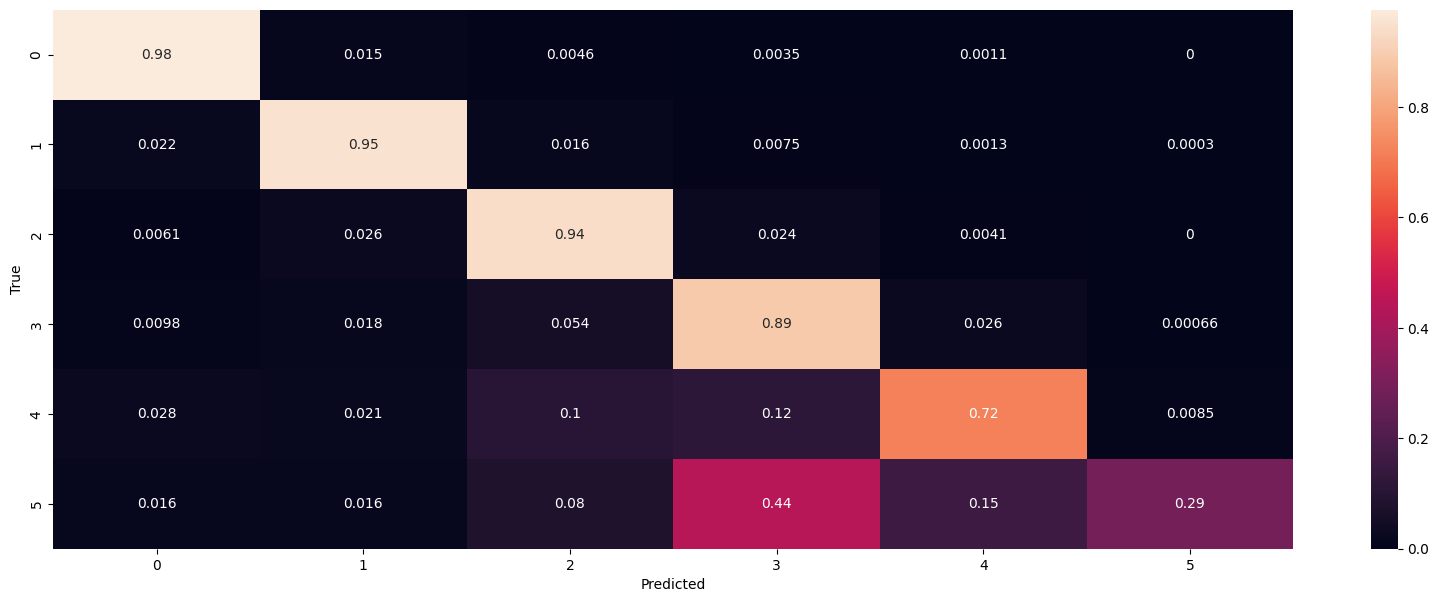

In [90]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")